In [18]:
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import time
import os
from IPython.display import clear_output
import datetime
from MapleKit.Utils.location import locateOnPicture, locateCenterOnPicture, pixelMatchesColor
import pytesseract
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
# from keras.models import Modelwww
# from keras.optimizers import Adam
# from Keras.applications.inception_resnet_v2 import InceptionResNetV2p
import glob
# from autoPyTorch.pipeline.image_classification import ImageClassificationPipeline
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
WORKPATH = "C:/Users/Johan/Documents/PycharmProjects/MaplestoryM-Assistant"
desired_window = "BlueStacks App Player"
adb_port = 11902
os.chdir(WORKPATH)

In [19]:
digits = datasets.load_digits()

In [20]:
digits.data


array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [21]:
target_size = (60, 65)

def read_and_resize(path, target_size):
    return cv2.resize(cv2.imread(path), target_size)/255

In [57]:
# Execute Once
AutoBattleStatusRawList = glob.glob("./raw_data/US/Status/raw_data/AutoBattle/*.png")
AutoQuestStatusRawList = glob.glob("./raw_data/US/Status/raw_data/AutoQuest/*.png")

for i in range(len(AutoBattleStatusRawList)):
    img = cv2.imread(AutoBattleStatusRawList[i])
    img = img[625:685, 390:455]
    img = cv2.resize(img, target_size)
    cv2.imwrite("./raw_data/US/Status/data/AutoBattle/"+str(i)+".png", img)

for i in range(len(AutoQuestStatusRawList)):
    img = cv2.imread(AutoQuestStatusRawList[i])
    img = img[625:685, 390:455]
    img = cv2.resize(img, target_size)
    cv2.imwrite("./raw_data/US/Status/data/AutoQuest/"+str(i)+".png", img)

In [58]:
img_path_list = glob.glob("./raw_data/US/status/data/*/*.*", recursive=True)
print(f"Data Size: {len(img_path_list)}")
img_cls = [os.path.basename(os.path.dirname(i)) for i in img_path_list]
classes = list(np.unique(img_cls))
Y = np.zeros((len(img_cls), len(classes)))

for r in range(len(img_cls)):
    Y[r, classes.index(img_cls[r])] = 1

X_img = []
for i in img_path_list:
    img = cv2.imread(i)
    X_img.append(img)
X_img = np.swapaxes(np.array(X_img), 1, 3)
print(X_img.shape)

Data Size: 26
(26, 3, 60, 65)


In [153]:
X_train, X_test, y_train, y_test = train_test_split(torch.FloatTensor(X_img), torch.LongTensor(Y), test_size=0.2, random_state=3)

In [73]:
from torch.utils.data import TensorDataset

ds_train = TensorDataset(X_train,y_train)
ds_test = TensorDataset(X_test, y_test)

In [103]:
trainloader = torch.utils.data.DataLoader(ds_train, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(ds_test, batch_size=10, shuffle=True)

In [143]:
class LeNet(nn.Module):
    # 一般在__init__中定义网络需要的操作算子，比如卷积、全连接算子等等
    def __init__(self):
        super(LeNet, self).__init__()
        # Conv2d的第一个参数是输入的channel数量，第二个是输出的channel数量，第三个是kernel size
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.conv2 = nn.Conv2d(4, 5, 5)
        # 由于上一层有16个channel输出，每个feature map大小为5*5，所以全连接层的输入是16*5*5
        self.fc1 = nn.Linear(5*12*13, 100)
        self.fc2 = nn.Linear(100, 16)
        # 最终有10类，所以最后一个全连接层输出数量是10
        self.fc3 = nn.Linear(16, 2)
        self.pool = nn.MaxPool2d(2, 2)
    # forward这个函数定义了前向传播的运算，只需要像写普通的python算数运算那样就可以了
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # print(x.shape)
        # 下面这步把二维特征图变为一维，这样全连接层才能处理
        x = x.view(-1, 5*12*13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = LeNet()

In [144]:
import torch.optim as optim

# CrossEntropyLoss就是我们需要的损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [149]:
print("Start Training...")
loss_list = []
for epoch in range(100):
    # 我们用一个变量来记录每100个batch的平均loss
    loss100 = 0.0
    # 我们的dataloader派上了用场
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs, labels # 注意需要复制到GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss100 += loss.item()
        if i % 1 == 0:
            print('[Epoch %d, Batch %5d] loss: %.9f' %
                  (epoch + 1, i + 1, loss100 / 1))
            loss_list.append(loss100/1)
            loss100 = 0.0
    # print(epoch)
print("Done Training!")

Start Training...
[Epoch 1, Batch     1] loss: 0.000134341
[Epoch 1, Batch     2] loss: 0.000149278
[Epoch 2, Batch     1] loss: 0.000144847
[Epoch 2, Batch     2] loss: 0.000141035
[Epoch 3, Batch     1] loss: 0.000060994
[Epoch 3, Batch     2] loss: 0.000219289
[Epoch 4, Batch     1] loss: 0.000136483
[Epoch 4, Batch     2] loss: 0.000145253
[Epoch 5, Batch     1] loss: 0.000058743
[Epoch 5, Batch     2] loss: 0.000217727
[Epoch 6, Batch     1] loss: 0.000128193
[Epoch 6, Batch     2] loss: 0.000146229
[Epoch 7, Batch     1] loss: 0.000145954
[Epoch 7, Batch     2] loss: 0.000126645
[Epoch 8, Batch     1] loss: 0.000115028
[Epoch 8, Batch     2] loss: 0.000157451
[Epoch 9, Batch     1] loss: 0.000201634
[Epoch 9, Batch     2] loss: 0.000067808
[Epoch 10, Batch     1] loss: 0.000087369
[Epoch 10, Batch     2] loss: 0.000180632
[Epoch 11, Batch     1] loss: 0.000079506
[Epoch 11, Batch     2] loss: 0.000186493
[Epoch 12, Batch     1] loss: 0.000121843
[Epoch 12, Batch     2] loss: 0.00

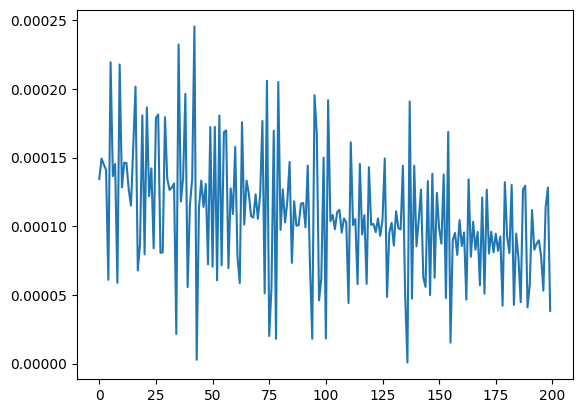

In [150]:
plt.plot(loss_list)

In [152]:
def test():
    net.eval()
    correct = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for Data, Label in testloader:
            Data = Data
            Label = Label
            test_output = net(Data)
            print(test_output)
            loss = criterion(test_output, Label)
            pred = torch.max(test_output, 1)[1]
            print(pred)
            print(Label)
            test_correct = (pred == torch.argmax(Label, 1)).sum()
            correct = correct + test_correct.item()
            test_loss = test_loss + loss.item()
    print(correct/len(X_test))
test()

tensor([[13.2963, -9.6568],
        [-6.0577,  9.2940],
        [11.8118, -8.6553],
        [-4.7089, 10.3876],
        [ 0.9062,  6.0035],
        [12.5504, -9.0928]])
tensor([0, 1, 0, 1, 1, 0])
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]])
0.6666666666666666
